In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MultiLabelBinarizer, scale
from sklearn.model_selection import KFold
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, mean_squared_error
from sklearn import svm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
directory='c:/users/da1933/desktop/cds/ids_project/'
#directory='~/desktop/idsproject/'

df1=pd.read_csv(directory+'wine/winemag-data-130k-v2.csv',index_col=0)
df2=pd.read_csv(directory+'wine/winemag-data_first150k.csv',index_col=0)
df=pd.concat([df1.drop(['taster_name','taster_twitter_handle','title'],axis=1),df2]).reset_index(drop=True)

In [3]:
df['over90']=df['points'].apply(lambda x: 1 if x>=90 else 0)
df['designation']=df['designation'].fillna('missing')
df['textlen']=df['description'].apply(lambda x: len(x))
df['textlen']=scale(df[['textlen']])
df['price']=df['price'].fillna(np.mean(df['price']))
df['price']=scale(df[['price']])

C:\Users\da1933\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.


### Encoding - needs repair

In [4]:
l_enc = LabelEncoder()
col1 = l_enc.fit_transform(df['country'].astype(str))
col2 = l_enc.fit_transform(df['variety'].astype(str))
col3 = l_enc.fit_transform(df['province'].astype(str))
df_enc = pd.DataFrame({'enc_country':col1,'enc_variety':col2,'enc_province':col3})

df=pd.concat([df,df_enc],axis=1)

In [5]:
#df=df[['price','enc_country','enc_province','enc_variety','textlen','over90']]
df=df[['enc_country','enc_province','enc_variety','textlen','over90','points']]

#one hot encoding
enc = OneHotEncoder()
X_enc = enc.fit_transform(X)

X_enc

In [6]:
# Feature identification
# If using price: 
#features=['price','enc_country','enc_province','enc_variety','textlen']
# If not using price: 
features=['enc_country','enc_province','enc_variety','textlen']

### Train-Test-Split

In [7]:
df=df.set_index(np.random.permutation(df.index.values)).sort_index()

# Determine split index:
split_index=int(np.round(df.shape[0]*.8))

# Assign training and testing datasets based on split index
train_df=df.iloc[:split_index,:]
test_df=df.iloc[split_index:,:]

trainX=train_df.drop(['over90'],axis=1)
trainY=train_df[['over90','points']]
testX=test_df.drop(['over90'],axis=1)
testY=test_df[['over90','points']]

### Cross Validation

In [8]:
def xVal(dataset, label_name, k,model):
    kf = KFold(n_splits=k)
    results=[]
    highest=0
    for train_idxs, test_idxs in kf.split(dataset.drop(label_name,1)):
        train=dataset.iloc[train_idxs]
        test=dataset.iloc[test_idxs]

        clf=model().fit(train.drop(label_name,1),train[label_name])
        auc=roc_auc_score(test[label_name], clf.predict_proba(test.drop(label_name,1))[:,1])
        score=clf.score(test.drop(label_name,axis=1),test[label_name])
        if score > highest:
            highest=score
            best_model=clf
        results.append((auc,score))
            
    return results,best_model

In [9]:
def plotAUC(truth, pred, lab):
    fpr, tpr, thresholds = roc_curve(truth, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label= lab+' (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")

# <h1><center>Models</center></h1>

## Classification

### 1) Naive Bayes  
#### a) Bernoulli

0.6808650765396939


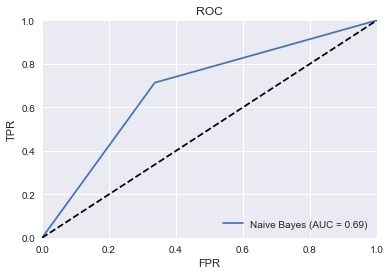

In [10]:
nb = BernoulliNB()
nb.fit(trainX[features], trainY['over90'])
nb_preds=nb.predict(testX[features])
print(nb.score(testX[features],testY['over90']))
plotAUC(testY['over90'],nb.predict(testX[features]),'Naive Bayes')

#### b) Gaussian

0.721502313990744


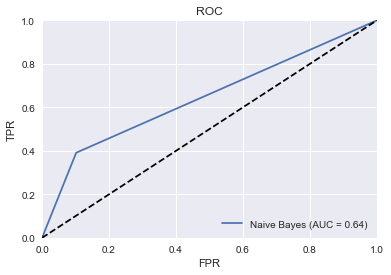

In [11]:
gnb = GaussianNB()
gnb.fit(trainX[features], trainY['over90'])
gnb_preds=gnb.predict(testX[features])
print(gnb.score(testX[features],testY['over90']))
plotAUC(testY['over90'],gnb.predict(testX[features]),'Naive Bayes')

### 2) Logistic Regression

0.7217871128515486


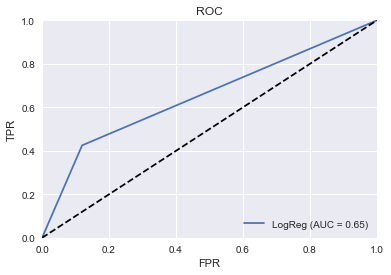

In [12]:
lr = LogisticRegression()
lr.fit(trainX[features],trainY['over90'])
lr_preds=lr.predict(testX[features])
print(lr.score(testX[features],testY['over90']))
plotAUC(testY['over90'],lr.predict(testX[features]),'LogReg')

### 3) KNN

0.7602705589177643


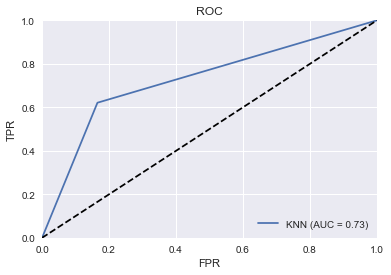

In [13]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(trainX[features],trainY['over90'])
knn_preds=knn.predict(testX[features])
print(knn.score(testX[features],testY['over90']))
plotAUC(testY['over90'],knn.predict(testX[features]),'KNN')

### 4) Decision Tree

0.7885368458526166


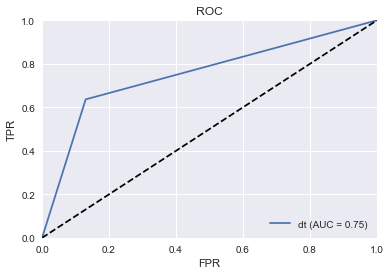

In [14]:
dt=DecisionTreeClassifier()
dt.fit(trainX[features],trainY['over90'])
dt_preds=dt.predict(testX[features])
print(dt.score(testX[features],testY['over90']))
plotAUC(testY['over90'],dt.predict(testX[features]),'dt')

### 5) Random Forest Classifier

0.7902278390886437


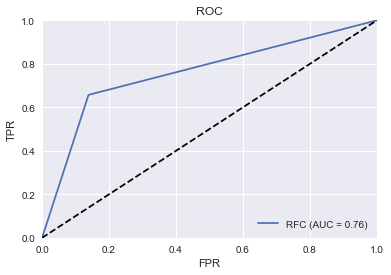

In [15]:
rfc=RandomForestClassifier(criterion='entropy')
rfc.fit(trainX[features],trainY['over90'])
rfc_preds=rfc.predict(testX[features])
print(rfc.score(testX[features],testY['over90']))
plotAUC(testY['over90'],rfc.predict(testX[features]),'RFC')

### 6) Gradient Boosted Classifier

0.7535777856888572


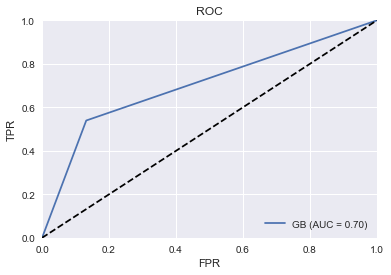

In [16]:
gbc=GradientBoostingClassifier()
gbc.fit(trainX[features],trainY['over90'])
gbc_preds=gbc.predict(testX[features])
print(gbc.score(testX[features],testY['over90']))
plotAUC(testY['over90'],gbc.predict(testX[features]),'GB')

### To add later ? Analyze how/why models' predictions are different?

In [17]:
print('NB and LR make {0:.2f}% similar predictions'.format(100*sum(nb_preds==lr_preds)/len(testY['over90'])))
print('NB and KNN make {0:.2f}% similar predictions'.format(100*sum(nb_preds==knn_preds)/len(testY['over90'])))
print('NB and DT make {0:.2f}% similar predictions'.format(100*sum(nb_preds==dt_preds)/len(testY['over90'])))
print('NB and RFC make {0:.2f}% similar predictions'.format(100*sum(nb_preds==rfc_preds)/len(testY['over90'])))
print('NB and GBC make {0:.2f}% similar predictions'.format(100*sum(nb_preds==gbc_preds)/len(testY['over90'])))
print('LR and KNN make {0:.2f}% similar predictions'.format(100*sum(lr_preds==knn_preds)/len(testY['over90'])))
print('LR and DT make {0:.2f}% similar predictions'.format(100*sum(lr_preds==dt_preds)/len(testY['over90'])))
print('LR and RFC make {0:.2f}% similar predictions'.format(100*sum(lr_preds==rfc_preds)/len(testY['over90'])))
print('LR and GBC make {0:.2f}% similar predictions'.format(100*sum(lr_preds==gbc_preds)/len(testY['over90'])))
print('KNN and DT make {0:.2f}% similar predictions'.format(100*sum(knn_preds==dt_preds)/len(testY['over90'])))
print('KNN and RFC make {0:.2f}% similar predictions'.format(100*sum(knn_preds==rfc_preds)/len(testY['over90'])))
print('KNN and GBT make {0:.2f}% similar predictions'.format(100*sum(knn_preds==gbc_preds)/len(testY['over90'])))
print('DT and RFC make {0:.2f}% similar predictions'.format(100*sum(dt_preds==rfc_preds)/len(testY['over90'])))
print('DT and GBC make {0:.2f}% similar predictions'.format(100*sum(dt_preds==gbc_preds)/len(testY['over90'])))
print('RFC and GBC make {0:.2f}% similar predictions'.format(100*sum(rfc_preds==gbc_preds)/len(testY['over90'])))

NB and LR make 75.82% similar predictions
NB and KNN make 70.81% similar predictions
NB and DT make 72.33% similar predictions
NB and RFC make 73.07% similar predictions
NB and GBC make 77.81% similar predictions
LR and KNN make 76.51% similar predictions
LR and DT make 77.84% similar predictions
LR and RFC make 77.66% similar predictions
LR and GBC make 87.61% similar predictions
KNN and DT make 86.00% similar predictions
KNN and RFC make 86.37% similar predictions
KNN and GBT make 80.04% similar predictions
DT and RFC make 95.28% similar predictions
DT and GBC make 82.30% similar predictions
RFC and GBC make 82.40% similar predictions


## Regression

### Random Forest Regression

In [25]:
mses=[]
d=[2**i for i in range(5,11)]
l=[2**i for i in range(11)]
for depth in d:
    for leaves in l:
        clf=RandomForestRegressor(max_depth=depth,min_samples_leaf=leaves)
        clf.fit(trainX[features],trainY['points'])
        mse=mean_squared_error(testY['points'],np.round(clf.predict(testX[features])))
        mses.append((depth,leaves,mse))
        print('Depth: {} Leaves: {} Mean Squared Error: {:.3f}'.format(depth,leaves,mse))

Depth: 32 Leaves: 1 Mean Squared Error: 4.810
Depth: 32 Leaves: 2 Mean Squared Error: 4.859
Depth: 32 Leaves: 4 Mean Squared Error: 4.946
Depth: 32 Leaves: 8 Mean Squared Error: 5.059
Depth: 32 Leaves: 16 Mean Squared Error: 5.188
Depth: 32 Leaves: 32 Mean Squared Error: 5.291
Depth: 32 Leaves: 64 Mean Squared Error: 5.401
Depth: 32 Leaves: 128 Mean Squared Error: 5.532
Depth: 32 Leaves: 256 Mean Squared Error: 5.684
Depth: 32 Leaves: 512 Mean Squared Error: 5.921
Depth: 32 Leaves: 1024 Mean Squared Error: 6.106
Depth: 64 Leaves: 1 Mean Squared Error: 4.810
Depth: 64 Leaves: 2 Mean Squared Error: 4.849
Depth: 64 Leaves: 4 Mean Squared Error: 4.950
Depth: 64 Leaves: 8 Mean Squared Error: 5.058
Depth: 64 Leaves: 16 Mean Squared Error: 5.193
Depth: 64 Leaves: 32 Mean Squared Error: 5.287
Depth: 64 Leaves: 64 Mean Squared Error: 5.417
Depth: 64 Leaves: 128 Mean Squared Error: 5.533
Depth: 64 Leaves: 256 Mean Squared Error: 5.693
Depth: 64 Leaves: 512 Mean Squared Error: 5.908
Depth: 64 Lea

In [ ]:
#best model parameters:
print('Best Model Paramters: ',mses[np.argmin([i[-1] for i in mses])])

In [47]:
# Best model:
clf=RandomForestRegressor(max_depth=1024,min_samples_leaf=1)
clf.fit(trainX[features],trainY['points'])
preds=np.round(clf.predict(testX[features]))
results=pd.DataFrame({'Predictions':preds,'Actual':testY['points']})
results=results.sort_values(by=['Actual']).reset_index(drop=True)

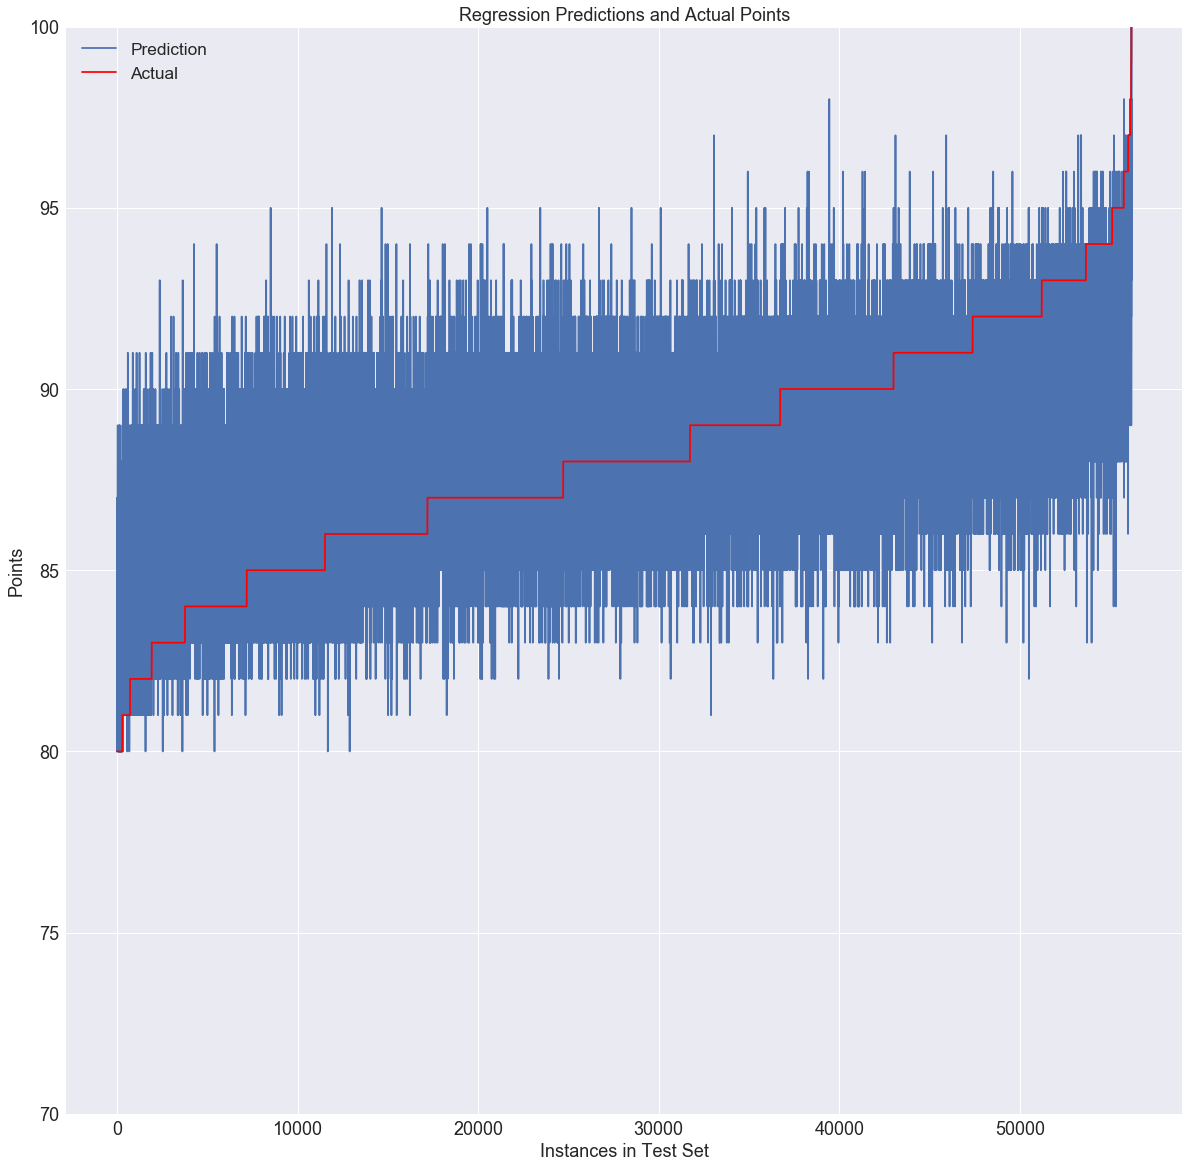

In [51]:
plt.figure(figsize=(20,20))
plt.plot(results['Predictions'],label='Prediction')
plt.plot(results['Actual'],'r',label='Actual')
plt.ylim(70,100)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel('Points',fontsize=18)
plt.xlabel('Instances in Test Set',fontsize=18)
plt.title('Regression Predictions and Actual Points',fontsize=18)
plt.legend(fontsize='xx-large')

In [55]:
# Mean predictions for corresponding point level
sort=np.round(results.groupby(['Actual']).mean()).reset_index()
q={}
for i,v in enumerate(sort['Actual']):
    q[v]=sort['Predictions'][i]
results['MeanPreds']=results['Actual'].map(q)

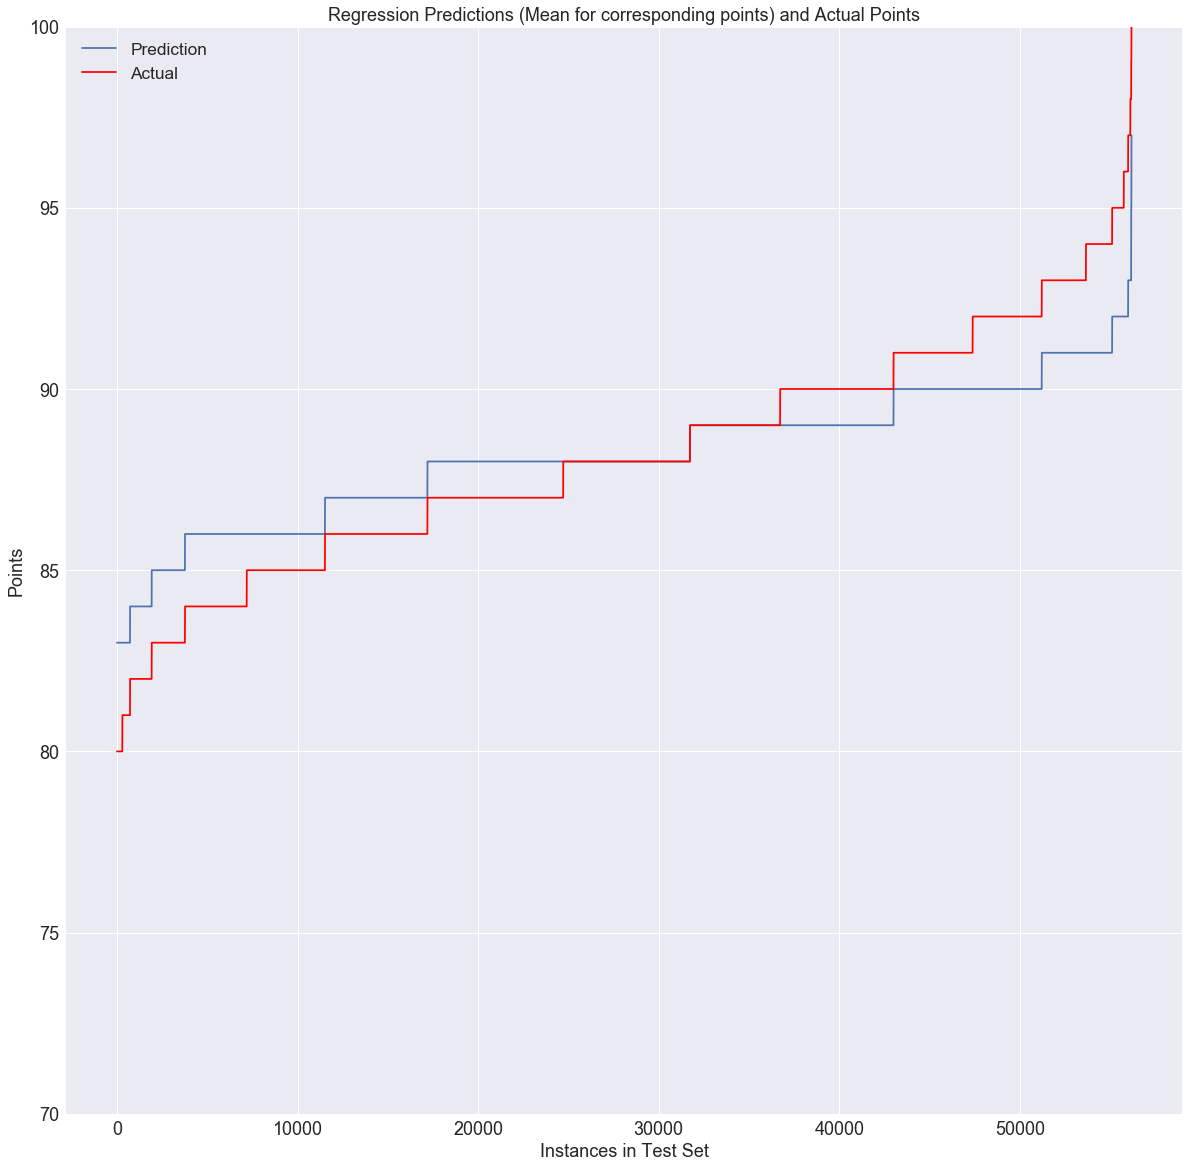

In [54]:
plt.figure(figsize=(20,20))
plt.plot(results['MeanPreds'],label='Prediction')
plt.plot(results['Actual'],'r',label='Actual')
plt.ylim(70,100)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel('Points',fontsize=18)
plt.xlabel('Instances in Test Set',fontsize=18)
plt.title('Regression Predictions (Mean for corresponding points) and Actual Points',fontsize=18)
plt.legend(fontsize='xx-large')